<a href="https://colab.research.google.com/github/DavoodSZ1993/Dive_into_Deep_Learning/blob/main/12_11_learningrate_scheduling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install d2l==1.0.0-alpha1.post0 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.0/93.0 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.2/121.2 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.9/84.9 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.2 MB/s eta 0:00:00


## 12.11 Learning Rate Scheduling

### 12.11.1 Toy Problem

In [18]:
%matplotlib inline
import torch
import math
from torch import nn
from torch.optim import lr_scheduler
from d2l import torch as d2l

In [23]:
def net_fn():
  model = nn.Sequential(
      nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Flatten(),
      nn.Linear(16 * 5 * 5, 120), nn.ReLU(),
      nn.Linear(120, 84), nn.ReLU(),
      nn.Linear(84, 10))
  return model

In [24]:
loss = nn.CrossEntropyLoss()
device = d2l.try_gpu()

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

In [25]:
def train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
          scheduler=None):
  net.to(device)
  animator = d2l.Animator(xlabel='epcoh', xlim=[0, num_epochs],
                          legend=['train loss', 'train acc', 'test acc'])
  for epoch in range(num_epochs):
    metric = d2l.Accumulator(3) # train_loss, train_acc, num_examples
    for i, (X, y) in enumerate(train_iter):
      net.train()
      trainer.zero_grad()
      X, y = X.to(device), y.to(device)
      y_hat = net(X)
      l = loss(y_hat, y)
      l.backward()
      trainer.step()
      with torch.no_grad():
        metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
      train_loss = metric[0] / metric[2]
      train_acc = metric[1] / metric[2]
      if (i + 1) % 50 == 0:
        animator.add(epoch + i / len(train_iter),
                     (train_loss, train_acc, None))
    
    test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
    animator.add(epoch+1, (None, None, test_acc))

    if scheduler:
      if scheduler.__module__ == lr_scheduler.__name__:
        # Using PyTorch In-Built scheduler
        scheduler.step()
      else:
        # Using custom defined scheduler
        for param_group in trainer.param_groups:
          param_group['lr'] = scheduler(epoch)

  print(f'train loss {train_loss: .3f}, train acc {train_acc:.3f}, test acc {test_acc:.3f}')

train loss  0.165, train acc 0.939, test acc 0.875


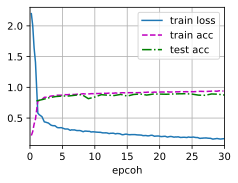

In [26]:
lr, num_epochs = 0.3, 30
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=lr)

train(net, train_iter, test_iter, num_epochs, loss, trainer, device)

### 12.11.2 Schedulers

In [27]:
lr = 0.1
trainer.param_groups[0]["lr"] = lr
print(f'learning rate is now {trainer.param_groups[0]["lr"]: .2f}')

learning rate is now  0.10


In [28]:
class SquareRootScheduler:
  def __init__(self, lr):
    self.lr = lr

  def __call__(self, num_update):
    return self.lr * pow(num_update +1.0, -0.5)

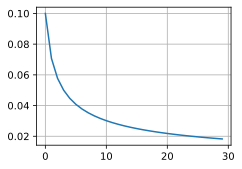

In [29]:
scheduler = SquareRootScheduler(lr=0.1)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

train loss  0.275, train acc 0.899, test acc 0.877


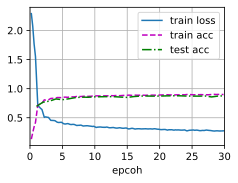

In [30]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device, scheduler)